# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.01929692 -0.15405606 -0.00796877  0.26203255] 0 1.0 False {}
state, action, reward, done, info: [-0.02237804  0.04117873 -0.00272812 -0.03315313] 1 1.0 False {}
state, action, reward, done, info: [-0.02155446  0.2363397  -0.00339118 -0.32669556] 1 1.0 False {}
state, action, reward, done, info: [-0.01682767  0.04126619 -0.00992509 -0.03508398] 0 1.0 False {}
state, action, reward, done, info: [-0.01600235  0.23652906 -0.01062677 -0.33088178] 1 1.0 False {}
state, action, reward, done, info: [-0.01127176  0.43180065 -0.01724441 -0.62689685] 1 1.0 False {}
state, action, reward, done, info: [-0.00263575  0.627159   -0.02978234 -0.92496041] 1 1.0 False {}
state, action, reward, done, info: [ 0.00990743  0.82267028 -0.04828155 -1.22685199] 1 1.0 False {}
state, action, reward, done, info: [ 0.02636083  1.01837936 -0.07281859 -1.53426277] 1 1.0 False {}
state, action, reward, done, info: [ 0.04672842  1.21429898 -0.10350385 -1.84875314] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, labelQs, cell, initial_state

In [9]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [37]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs, labelQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    lossQtgt = tf.reduce_mean(tf.square(Qs - targetQs)) # next state, next action and nextQs
    lossQlbl = tf.reduce_mean(tf.square(Qs - labelQs)) # current state, action, and currentQs
    lossQtgt_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                           labels=tf.nn.sigmoid(targetQs)))
    lossQlbl_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
                                                                           labels=tf.nn.sigmoid(labelQs)))
    loss = lossQtgt + lossQlbl + lossQtgt_sigm + lossQlbl_sigm
    return actions_logits, final_state, loss, lossQtgt, lossQlbl, lossQtgt_sigm, lossQlbl_sigm

In [38]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [39]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.labelQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss, self.lossQtgt, self.lossQlbl, self.lossQtgt_sigm, self.lossQlbl_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, labelQs=self.labelQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [40]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [41]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [42]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [43]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [44]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [45]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
memory.buffer[0]

[array([ 0.0068957 ,  0.00404566, -0.02286297,  0.00812363]),
 1,
 array([ 0.00697661,  0.19948791, -0.02270049, -0.29168426]),
 1.0,
 0.0]

In [47]:
# states, rewards, actions

In [ ]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        lossQlbl_batch, lossQlbl_sigm_batch, lossQtgt_batch, lossQtgt_sigm_batch = [], [], [], []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: states, 
                                                   model.initial_state: initial_states[0].reshape([1, -1])})
            labelQs = np.max(actions_logits, axis=1)
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states, 
                                                        model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _, lossQlbl, lossQlbl_sigm, lossQtgt, lossQtgt_sigm = sess.run([model.loss, model.opt, 
                                                                                  model.lossQlbl, 
                                                                                  model.lossQlbl_sigm, 
                                                                                  model.lossQtgt, 
                                                                                  model.lossQtgt_sigm], 
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs,
                                                         model.labelQs: labelQs,
                                                         model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            lossQlbl_batch.append(lossQlbl)
            lossQlbl_sigm_batch.append(lossQlbl_sigm)
            lossQtgt_batch.append(lossQtgt)
            lossQtgt_sigm_batch.append(lossQtgt_sigm)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'meanLossQlbl: {:.4f}'.format(np.mean(lossQlbl_batch)),
              'meanLossQlbl_sigm: {:.4f}'.format(np.mean(lossQlbl_sigm_batch)),
              'meanLossQtgt: {:.4f}'.format(np.mean(lossQtgt_batch)),
              'meanLossQtgt_sigm: {:.4f}'.format(np.mean(lossQtgt_sigm_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model4.ckpt')

Episode: 0 meanReward: 13.0000 meanLoss: 2.4191 meanLossQlbl: 0.0857 meanLossQlbl_sigm: 0.6443 meanLossQtgt: 1.1021 meanLossQtgt_sigm: 0.5870 ExploreP: 0.9987
Episode: 1 meanReward: 16.0000 meanLoss: 2.4825 meanLossQlbl: 0.0473 meanLossQlbl_sigm: 0.2381 meanLossQtgt: 1.9933 meanLossQtgt_sigm: 0.2039 ExploreP: 0.9968
Episode: 2 meanReward: 19.3333 meanLoss: 4.9990 meanLossQlbl: 1.2001 meanLossQlbl_sigm: 0.1493 meanLossQtgt: 3.4026 meanLossQtgt_sigm: 0.2469 ExploreP: 0.9943
Episode: 3 meanReward: 18.2500 meanLoss: 8.7723 meanLossQlbl: 2.6923 meanLossQlbl_sigm: 0.2559 meanLossQtgt: 5.4928 meanLossQtgt_sigm: 0.3314 ExploreP: 0.9928
Episode: 4 meanReward: 18.2000 meanLoss: 5.2933 meanLossQlbl: 0.1563 meanLossQlbl_sigm: 0.0116 meanLossQtgt: 4.9729 meanLossQtgt_sigm: 0.1524 ExploreP: 0.9910
Episode: 5 meanReward: 16.8333 meanLoss: 6.4541 meanLossQlbl: 0.1934 meanLossQlbl_sigm: 0.0003 meanLossQtgt: 6.0901 meanLossQtgt_sigm: 0.1701 ExploreP: 0.9901
Episode: 6 meanReward: 17.4286 meanLoss: 6.008

Episode: 51 meanReward: 21.5312 meanLoss: 70.3398 meanLossQlbl: 2.3562 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 67.4151 meanLossQtgt_sigm: 0.5686 ExploreP: 0.8981
Episode: 52 meanReward: 21.4375 meanLoss: 57.8995 meanLossQlbl: 3.8054 meanLossQlbl_sigm: 0.0001 meanLossQtgt: 53.6789 meanLossQtgt_sigm: 0.4151 ExploreP: 0.8970
Episode: 53 meanReward: 21.2188 meanLoss: 66.4481 meanLossQlbl: 5.4058 meanLossQlbl_sigm: 0.0001 meanLossQtgt: 60.6123 meanLossQtgt_sigm: 0.4299 ExploreP: 0.8962
Episode: 54 meanReward: 20.8750 meanLoss: 63.5829 meanLossQlbl: 4.1102 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 59.0032 meanLossQtgt_sigm: 0.4695 ExploreP: 0.8946
Episode: 55 meanReward: 20.9062 meanLoss: 61.8647 meanLossQlbl: 2.2045 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 59.2359 meanLossQtgt_sigm: 0.4243 ExploreP: 0.8921
Episode: 56 meanReward: 21.6562 meanLoss: 12.9759 meanLossQlbl: 1.6465 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.2207 meanLossQtgt_sigm: 0.1088 ExploreP: 0.8875
Episode: 57 meanReward: 21.7

Episode: 102 meanReward: 24.1875 meanLoss: 17.9597 meanLossQlbl: 0.8432 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.9601 meanLossQtgt_sigm: 0.1564 ExploreP: 0.8025
Episode: 103 meanReward: 23.2812 meanLoss: 19.8980 meanLossQlbl: 2.2411 meanLossQlbl_sigm: 0.0083 meanLossQtgt: 17.4860 meanLossQtgt_sigm: 0.1626 ExploreP: 0.8011
Episode: 104 meanReward: 23.1250 meanLoss: 534.6590 meanLossQlbl: 268.5401 meanLossQlbl_sigm: 0.5973 meanLossQtgt: 264.8720 meanLossQtgt_sigm: 0.6496 ExploreP: 0.8000
Episode: 105 meanReward: 23.2188 meanLoss: 562.6449 meanLossQlbl: 311.9095 meanLossQlbl_sigm: 0.6474 meanLossQtgt: 249.4172 meanLossQtgt_sigm: 0.6709 ExploreP: 0.7984
Episode: 106 meanReward: 22.3125 meanLoss: 274.7181 meanLossQlbl: 143.6965 meanLossQlbl_sigm: 0.6550 meanLossQtgt: 129.6999 meanLossQtgt_sigm: 0.6668 ExploreP: 0.7957
Episode: 107 meanReward: 22.3125 meanLoss: 30.3212 meanLossQlbl: 1.4376 meanLossQlbl_sigm: 0.0318 meanLossQtgt: 28.5920 meanLossQtgt_sigm: 0.2598 ExploreP: 0.7947
Episode: 1

Episode: 153 meanReward: 38.6562 meanLoss: 210.1166 meanLossQlbl: 5.2735 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 203.9228 meanLossQtgt_sigm: 0.9203 ExploreP: 0.6743
Episode: 154 meanReward: 38.8438 meanLoss: 64.8374 meanLossQlbl: 7.9590 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 56.5380 meanLossQtgt_sigm: 0.3404 ExploreP: 0.6719
Episode: 155 meanReward: 36.7500 meanLoss: 79.9700 meanLossQlbl: 3.1841 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 76.3698 meanLossQtgt_sigm: 0.4162 ExploreP: 0.6698
Episode: 156 meanReward: 36.5625 meanLoss: 31.5129 meanLossQlbl: 4.9022 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 26.4069 meanLossQtgt_sigm: 0.2038 ExploreP: 0.6681
Episode: 157 meanReward: 35.8438 meanLoss: 39.1934 meanLossQlbl: 6.8230 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 32.1444 meanLossQtgt_sigm: 0.2260 ExploreP: 0.6672
Episode: 158 meanReward: 34.5625 meanLoss: 80.4160 meanLossQlbl: 7.8032 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 72.1481 meanLossQtgt_sigm: 0.4647 ExploreP: 0.6655
Episode: 159 meanRew

Episode: 204 meanReward: 52.1875 meanLoss: 43.0287 meanLossQlbl: 18.3673 meanLossQlbl_sigm: 0.0228 meanLossQtgt: 24.5613 meanLossQtgt_sigm: 0.0773 ExploreP: 0.5304
Episode: 205 meanReward: 56.5312 meanLoss: 12.0667 meanLossQlbl: 2.7907 meanLossQlbl_sigm: 0.0005 meanLossQtgt: 9.2553 meanLossQtgt_sigm: 0.0201 ExploreP: 0.5195
Episode: 206 meanReward: 56.7812 meanLoss: 56.0452 meanLossQlbl: 12.4094 meanLossQlbl_sigm: 0.0217 meanLossQtgt: 43.5695 meanLossQtgt_sigm: 0.0446 ExploreP: 0.5183
Episode: 207 meanReward: 56.5312 meanLoss: 140.0465 meanLossQlbl: 6.7122 meanLossQlbl_sigm: 0.0065 meanLossQtgt: 132.8808 meanLossQtgt_sigm: 0.4469 ExploreP: 0.5174
Episode: 208 meanReward: 52.2500 meanLoss: 176.0225 meanLossQlbl: 17.2799 meanLossQlbl_sigm: 0.0008 meanLossQtgt: 158.2757 meanLossQtgt_sigm: 0.4661 ExploreP: 0.5168
Episode: 209 meanReward: 52.8125 meanLoss: 95.8518 meanLossQlbl: 30.2592 meanLossQlbl_sigm: 0.0005 meanLossQtgt: 65.3662 meanLossQtgt_sigm: 0.2259 ExploreP: 0.5150
Episode: 210 me

Episode: 254 meanReward: 81.3125 meanLoss: 79.7569 meanLossQlbl: 2.4276 meanLossQlbl_sigm: 0.0035 meanLossQtgt: 77.0424 meanLossQtgt_sigm: 0.2834 ExploreP: 0.3690
Episode: 255 meanReward: 74.8750 meanLoss: 135.9362 meanLossQlbl: 33.2649 meanLossQlbl_sigm: 0.1220 meanLossQtgt: 102.2079 meanLossQtgt_sigm: 0.3414 ExploreP: 0.3686
Episode: 256 meanReward: 75.3750 meanLoss: 92.8270 meanLossQlbl: 31.9938 meanLossQlbl_sigm: 0.0838 meanLossQtgt: 60.5237 meanLossQtgt_sigm: 0.2256 ExploreP: 0.3665
Episode: 257 meanReward: 88.8125 meanLoss: 72.8836 meanLossQlbl: 31.5879 meanLossQlbl_sigm: 0.0219 meanLossQtgt: 41.2052 meanLossQtgt_sigm: 0.0687 ExploreP: 0.3491
Episode: 258 meanReward: 88.7812 meanLoss: 341.9483 meanLossQlbl: 51.2342 meanLossQlbl_sigm: 0.0158 meanLossQtgt: 289.7667 meanLossQtgt_sigm: 0.9317 ExploreP: 0.3481
Episode: 259 meanReward: 88.5938 meanLoss: 476.0798 meanLossQlbl: 40.2615 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 434.7770 meanLossQtgt_sigm: 1.0413 ExploreP: 0.3477
Episode: 26

Episode: 304 meanReward: 123.5625 meanLoss: 12.2523 meanLossQlbl: 0.2122 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 12.0037 meanLossQtgt_sigm: 0.0364 ExploreP: 0.2184
Episode: 305 meanReward: 123.2500 meanLoss: 408.5829 meanLossQlbl: 0.5480 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 407.0576 meanLossQtgt_sigm: 0.9774 ExploreP: 0.2181
Episode: 306 meanReward: 127.9062 meanLoss: 78.3341 meanLossQlbl: 2.8185 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 75.3663 meanLossQtgt_sigm: 0.1493 ExploreP: 0.2141
Episode: 307 meanReward: 124.7812 meanLoss: 40.5240 meanLossQlbl: 1.7900 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 38.5844 meanLossQtgt_sigm: 0.1495 ExploreP: 0.2119
Episode: 308 meanReward: 121.9062 meanLoss: 13.0583 meanLossQlbl: 1.5008 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.4994 meanLossQtgt_sigm: 0.0581 ExploreP: 0.2092
Episode: 309 meanReward: 131.9375 meanLoss: 8.8176 meanLossQlbl: 0.5127 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 8.2641 meanLossQtgt_sigm: 0.0408 ExploreP: 0.2027
Episode: 310 mea

Episode: 354 meanReward: 132.1875 meanLoss: 52.5567 meanLossQlbl: 1.3073 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 51.0914 meanLossQtgt_sigm: 0.1580 ExploreP: 0.1147
Episode: 355 meanReward: 130.1250 meanLoss: 37.3938 meanLossQlbl: 0.3572 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 36.8771 meanLossQtgt_sigm: 0.1595 ExploreP: 0.1137
Episode: 356 meanReward: 124.6875 meanLoss: 16.6217 meanLossQlbl: 0.2695 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.2556 meanLossQtgt_sigm: 0.0966 ExploreP: 0.1126
Episode: 357 meanReward: 122.6875 meanLoss: 29.7497 meanLossQlbl: 0.1402 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 29.4354 meanLossQtgt_sigm: 0.1741 ExploreP: 0.1119
Episode: 358 meanReward: 121.3750 meanLoss: 12.2372 meanLossQlbl: 0.4625 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.6956 meanLossQtgt_sigm: 0.0791 ExploreP: 0.1107
Episode: 359 meanReward: 120.5938 meanLoss: 20.1653 meanLossQlbl: 0.6885 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 19.3682 meanLossQtgt_sigm: 0.1086 ExploreP: 0.1097
Episode: 360 mea

Episode: 405 meanReward: 200.2500 meanLoss: 50.6270 meanLossQlbl: 0.4803 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 49.9997 meanLossQtgt_sigm: 0.1470 ExploreP: 0.0517
Episode: 406 meanReward: 199.6250 meanLoss: 58.8724 meanLossQlbl: 1.4115 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 57.1094 meanLossQtgt_sigm: 0.3515 ExploreP: 0.0516
Episode: 407 meanReward: 203.2188 meanLoss: 30.3672 meanLossQlbl: 1.9150 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 28.3471 meanLossQtgt_sigm: 0.1051 ExploreP: 0.0510
Episode: 408 meanReward: 210.3750 meanLoss: 13.2233 meanLossQlbl: 1.1119 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 12.0743 meanLossQtgt_sigm: 0.0371 ExploreP: 0.0500
Episode: 409 meanReward: 225.5938 meanLoss: 15.9604 meanLossQlbl: 0.2133 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 15.7039 meanLossQtgt_sigm: 0.0432 ExploreP: 0.0480
Episode: 410 meanReward: 239.3125 meanLoss: 21.6340 meanLossQlbl: 0.1018 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 21.4792 meanLossQtgt_sigm: 0.0530 ExploreP: 0.0462
Episode: 411 mea

Episode: 455 meanReward: 259.6250 meanLoss: 48.0971 meanLossQlbl: 0.7759 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 47.1389 meanLossQtgt_sigm: 0.1824 ExploreP: 0.0205
Episode: 456 meanReward: 257.7188 meanLoss: 9.1200 meanLossQlbl: 0.0827 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 9.0025 meanLossQtgt_sigm: 0.0348 ExploreP: 0.0201
Episode: 457 meanReward: 243.8438 meanLoss: 90.5600 meanLossQlbl: 0.6694 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 89.5651 meanLossQtgt_sigm: 0.3255 ExploreP: 0.0200
Episode: 458 meanReward: 242.1250 meanLoss: 204.6215 meanLossQlbl: 0.8700 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 203.0599 meanLossQtgt_sigm: 0.6915 ExploreP: 0.0200
Episode: 459 meanReward: 235.6875 meanLoss: 30.9482 meanLossQlbl: 1.6938 meanLossQlbl_sigm: 0.0032 meanLossQtgt: 29.1468 meanLossQtgt_sigm: 0.1044 ExploreP: 0.0199
Episode: 460 meanReward: 236.9062 meanLoss: 8.4869 meanLossQlbl: 0.1570 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 8.3026 meanLossQtgt_sigm: 0.0272 ExploreP: 0.0194
Episode: 461 meanR

Episode: 506 meanReward: 299.6875 meanLoss: 18.8643 meanLossQlbl: 0.0543 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 18.7588 meanLossQtgt_sigm: 0.0511 ExploreP: 0.0126
Episode: 507 meanReward: 284.5312 meanLoss: 276.2614 meanLossQlbl: 0.6498 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 274.7901 meanLossQtgt_sigm: 0.8215 ExploreP: 0.0126
Episode: 508 meanReward: 269.3750 meanLoss: 467.9148 meanLossQlbl: 2.8143 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 463.6615 meanLossQtgt_sigm: 1.4391 ExploreP: 0.0126
Episode: 509 meanReward: 254.2188 meanLoss: 316.4411 meanLossQlbl: 1.5684 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 313.7624 meanLossQtgt_sigm: 1.1104 ExploreP: 0.0126
Episode: 510 meanReward: 238.9062 meanLoss: 151.1127 meanLossQlbl: 2.0133 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 148.4815 meanLossQtgt_sigm: 0.6178 ExploreP: 0.0126
Episode: 511 meanReward: 223.6250 meanLoss: 136.3774 meanLossQlbl: 3.3904 meanLossQlbl_sigm: 0.0108 meanLossQtgt: 132.5895 meanLossQtgt_sigm: 0.3868 ExploreP: 0.0126
Episod

Episode: 556 meanReward: 172.2188 meanLoss: 19.6297 meanLossQlbl: 0.7079 meanLossQlbl_sigm: 0.0042 meanLossQtgt: 18.8740 meanLossQtgt_sigm: 0.0435 ExploreP: 0.0110
Episode: 557 meanReward: 171.6562 meanLoss: 34.9937 meanLossQlbl: 0.4989 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 34.3857 meanLossQtgt_sigm: 0.1092 ExploreP: 0.0110
Episode: 558 meanReward: 183.5000 meanLoss: 7.7192 meanLossQlbl: 0.1638 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 7.5305 meanLossQtgt_sigm: 0.0249 ExploreP: 0.0109
Episode: 559 meanReward: 198.6250 meanLoss: 13.9540 meanLossQlbl: 0.6428 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 13.2730 meanLossQtgt_sigm: 0.0382 ExploreP: 0.0109
Episode: 560 meanReward: 198.7812 meanLoss: 337.3274 meanLossQlbl: 0.9371 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 335.5134 meanLossQtgt_sigm: 0.8769 ExploreP: 0.0109
Episode: 561 meanReward: 211.0938 meanLoss: 22.8340 meanLossQlbl: 0.4733 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 22.3019 meanLossQtgt_sigm: 0.0588 ExploreP: 0.0108
Episode: 562 mea

Episode: 606 meanReward: 232.1250 meanLoss: 27.3482 meanLossQlbl: 0.2387 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 27.0333 meanLossQtgt_sigm: 0.0762 ExploreP: 0.0102
Episode: 607 meanReward: 243.4062 meanLoss: 14.9233 meanLossQlbl: 0.1253 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.7528 meanLossQtgt_sigm: 0.0452 ExploreP: 0.0102
Episode: 608 meanReward: 252.8438 meanLoss: 15.8057 meanLossQlbl: 0.1017 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 15.6572 meanLossQtgt_sigm: 0.0469 ExploreP: 0.0102
Episode: 609 meanReward: 253.1875 meanLoss: 246.7351 meanLossQlbl: 1.1612 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 244.8107 meanLossQtgt_sigm: 0.7633 ExploreP: 0.0102
Episode: 610 meanReward: 257.9688 meanLoss: 42.4768 meanLossQlbl: 0.5454 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 41.8016 meanLossQtgt_sigm: 0.1298 ExploreP: 0.0102
Episode: 611 meanReward: 273.1875 meanLoss: 13.7259 meanLossQlbl: 0.1287 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 13.5547 meanLossQtgt_sigm: 0.0424 ExploreP: 0.0102
Episode: 612 m

Episode: 656 meanReward: 218.3438 meanLoss: 46.2866 meanLossQlbl: 1.4445 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 44.7490 meanLossQtgt_sigm: 0.0931 ExploreP: 0.0101
Episode: 657 meanReward: 221.4375 meanLoss: 55.0946 meanLossQlbl: 2.4398 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 52.5431 meanLossQtgt_sigm: 0.1117 ExploreP: 0.0101
Episode: 658 meanReward: 224.1562 meanLoss: 14.0210 meanLossQlbl: 0.2363 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 13.7276 meanLossQtgt_sigm: 0.0570 ExploreP: 0.0101
Episode: 659 meanReward: 213.3438 meanLoss: 19.1082 meanLossQlbl: 0.1232 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 18.8912 meanLossQtgt_sigm: 0.0937 ExploreP: 0.0101
Episode: 660 meanReward: 212.8125 meanLoss: 17.1210 meanLossQlbl: 0.0292 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.9998 meanLossQtgt_sigm: 0.0920 ExploreP: 0.0101
Episode: 661 meanReward: 212.4688 meanLoss: 21.3695 meanLossQlbl: 0.5347 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 20.7405 meanLossQtgt_sigm: 0.0943 ExploreP: 0.0101
Episode: 662 mea

Episode: 706 meanReward: 287.4062 meanLoss: 19.9967 meanLossQlbl: 2.8605 meanLossQlbl_sigm: 0.0104 meanLossQtgt: 17.0886 meanLossQtgt_sigm: 0.0373 ExploreP: 0.0100
Episode: 707 meanReward: 279.5625 meanLoss: 16.9089 meanLossQlbl: 0.4093 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.4365 meanLossQtgt_sigm: 0.0631 ExploreP: 0.0100
Episode: 708 meanReward: 264.8438 meanLoss: 109.2116 meanLossQlbl: 4.9237 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 103.9027 meanLossQtgt_sigm: 0.3853 ExploreP: 0.0100
Episode: 709 meanReward: 275.0312 meanLoss: 8.5989 meanLossQlbl: 0.7429 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 7.8237 meanLossQtgt_sigm: 0.0323 ExploreP: 0.0100
Episode: 710 meanReward: 290.0312 meanLoss: 16.9498 meanLossQlbl: 0.1675 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.7344 meanLossQtgt_sigm: 0.0480 ExploreP: 0.0100
Episode: 711 meanReward: 302.3125 meanLoss: 20.7033 meanLossQlbl: 0.0912 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 20.5534 meanLossQtgt_sigm: 0.0587 ExploreP: 0.0100
Episode: 712 mea

Episode: 756 meanReward: 278.6875 meanLoss: 242.7796 meanLossQlbl: 0.2110 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 241.8035 meanLossQtgt_sigm: 0.7651 ExploreP: 0.0100
Episode: 757 meanReward: 275.1562 meanLoss: 26.0671 meanLossQlbl: 0.4607 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 25.5288 meanLossQtgt_sigm: 0.0776 ExploreP: 0.0100
Episode: 758 meanReward: 275.1875 meanLoss: 7.5984 meanLossQlbl: 0.2042 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 7.3639 meanLossQtgt_sigm: 0.0303 ExploreP: 0.0100
Episode: 759 meanReward: 260.5312 meanLoss: 301.7373 meanLossQlbl: 2.0639 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 298.8329 meanLossQtgt_sigm: 0.8406 ExploreP: 0.0100
Episode: 760 meanReward: 245.4375 meanLoss: 253.9808 meanLossQlbl: 0.7790 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 252.4408 meanLossQtgt_sigm: 0.7610 ExploreP: 0.0100
Episode: 761 meanReward: 260.2188 meanLoss: 10.0336 meanLossQlbl: 1.3828 meanLossQlbl_sigm: 0.0001 meanLossQtgt: 8.6292 meanLossQtgt_sigm: 0.0214 ExploreP: 0.0100
Episode: 762 

Episode: 806 meanReward: 269.4375 meanLoss: 351.2963 meanLossQlbl: 0.3927 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 349.6387 meanLossQtgt_sigm: 1.2649 ExploreP: 0.0100
Episode: 807 meanReward: 277.2812 meanLoss: 31.0276 meanLossQlbl: 0.4971 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 30.4181 meanLossQtgt_sigm: 0.1124 ExploreP: 0.0100
Episode: 808 meanReward: 292.5312 meanLoss: 16.7477 meanLossQlbl: 0.4121 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.2941 meanLossQtgt_sigm: 0.0415 ExploreP: 0.0100
Episode: 809 meanReward: 294.0312 meanLoss: 124.3513 meanLossQlbl: 1.0114 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 123.0199 meanLossQtgt_sigm: 0.3200 ExploreP: 0.0100
Episode: 810 meanReward: 301.6250 meanLoss: 7.0715 meanLossQlbl: 0.1144 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 6.9277 meanLossQtgt_sigm: 0.0294 ExploreP: 0.0100
Episode: 811 meanReward: 287.1875 meanLoss: 245.0649 meanLossQlbl: 1.0442 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 243.3372 meanLossQtgt_sigm: 0.6835 ExploreP: 0.0100
Episode: 812

Episode: 856 meanReward: 241.0000 meanLoss: 228.3470 meanLossQlbl: 0.1474 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 227.4736 meanLossQtgt_sigm: 0.7260 ExploreP: 0.0100
Episode: 857 meanReward: 241.0000 meanLoss: 10.9558 meanLossQlbl: 0.4163 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 10.5076 meanLossQtgt_sigm: 0.0320 ExploreP: 0.0100
Episode: 858 meanReward: 229.4062 meanLoss: 69.9328 meanLossQlbl: 0.4887 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 69.2512 meanLossQtgt_sigm: 0.1929 ExploreP: 0.0100
Episode: 859 meanReward: 218.2188 meanLoss: 26.9756 meanLossQlbl: 0.3329 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 26.5202 meanLossQtgt_sigm: 0.1225 ExploreP: 0.0100
Episode: 860 meanReward: 229.4688 meanLoss: 4.2845 meanLossQlbl: 0.0861 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 4.1763 meanLossQtgt_sigm: 0.0220 ExploreP: 0.0100
Episode: 861 meanReward: 218.4688 meanLoss: 59.5248 meanLossQlbl: 0.6515 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 58.7054 meanLossQtgt_sigm: 0.1680 ExploreP: 0.0100
Episode: 862 mea

Episode: 907 meanReward: 172.8125 meanLoss: 164.9460 meanLossQlbl: 3.3340 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 161.0316 meanLossQtgt_sigm: 0.5803 ExploreP: 0.0100
Episode: 908 meanReward: 180.2188 meanLoss: 22.1643 meanLossQlbl: 1.7293 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 20.3769 meanLossQtgt_sigm: 0.0581 ExploreP: 0.0100
Episode: 909 meanReward: 171.5625 meanLoss: 30.2225 meanLossQlbl: 0.2986 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 29.8306 meanLossQtgt_sigm: 0.0932 ExploreP: 0.0100
Episode: 910 meanReward: 185.8750 meanLoss: 12.2513 meanLossQlbl: 0.2278 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.9837 meanLossQtgt_sigm: 0.0398 ExploreP: 0.0100
Episode: 911 meanReward: 174.1250 meanLoss: 62.2758 meanLossQlbl: 0.1336 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 61.9546 meanLossQtgt_sigm: 0.1876 ExploreP: 0.0100
Episode: 912 meanReward: 178.9375 meanLoss: 14.1788 meanLossQlbl: 0.3941 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 13.7208 meanLossQtgt_sigm: 0.0639 ExploreP: 0.0100
Episode: 913 m

Episode: 957 meanReward: 230.8125 meanLoss: 42.4189 meanLossQlbl: 0.6268 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 41.6601 meanLossQtgt_sigm: 0.1320 ExploreP: 0.0100
Episode: 958 meanReward: 228.0312 meanLoss: 65.3339 meanLossQlbl: 0.4819 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 64.6419 meanLossQtgt_sigm: 0.2101 ExploreP: 0.0100
Episode: 959 meanReward: 231.5938 meanLoss: 26.0764 meanLossQlbl: 0.1561 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 25.8364 meanLossQtgt_sigm: 0.0840 ExploreP: 0.0100
Episode: 960 meanReward: 233.8125 meanLoss: 61.0785 meanLossQlbl: 0.5517 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 60.3268 meanLossQtgt_sigm: 0.2000 ExploreP: 0.0100
Episode: 961 meanReward: 222.2500 meanLoss: 50.7564 meanLossQlbl: 0.3839 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 50.2054 meanLossQtgt_sigm: 0.1671 ExploreP: 0.0100
Episode: 962 meanReward: 207.1562 meanLoss: 225.4722 meanLossQlbl: 0.0492 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 224.6841 meanLossQtgt_sigm: 0.7390 ExploreP: 0.0100
Episode: 963 m

Episode: 1007 meanReward: 188.0938 meanLoss: 237.0493 meanLossQlbl: 67.9257 meanLossQlbl_sigm: 0.0513 meanLossQtgt: 168.6368 meanLossQtgt_sigm: 0.4355 ExploreP: 0.0100
Episode: 1008 meanReward: 190.6250 meanLoss: 1722.4081 meanLossQlbl: 886.2593 meanLossQlbl_sigm: 0.4765 meanLossQtgt: 835.0741 meanLossQtgt_sigm: 0.5983 ExploreP: 0.0100
Episode: 1009 meanReward: 195.8125 meanLoss: 245.5590 meanLossQlbl: 127.6908 meanLossQlbl_sigm: 0.0581 meanLossQtgt: 117.7486 meanLossQtgt_sigm: 0.0615 ExploreP: 0.0100
Episode: 1010 meanReward: 193.0000 meanLoss: 153.5639 meanLossQlbl: 0.9546 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 152.0618 meanLossQtgt_sigm: 0.5476 ExploreP: 0.0100
Episode: 1011 meanReward: 194.9062 meanLoss: 21.6615 meanLossQlbl: 0.0782 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 21.5089 meanLossQtgt_sigm: 0.0744 ExploreP: 0.0100
Episode: 1012 meanReward: 189.1562 meanLoss: 178.8466 meanLossQlbl: 0.1298 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 178.0593 meanLossQtgt_sigm: 0.6575 ExploreP: 0

Episode: 1057 meanReward: 275.0000 meanLoss: 15.0946 meanLossQlbl: 0.0529 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.9956 meanLossQtgt_sigm: 0.0460 ExploreP: 0.0100
Episode: 1058 meanReward: 282.2812 meanLoss: 30.3810 meanLossQlbl: 0.4822 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 29.8050 meanLossQtgt_sigm: 0.0938 ExploreP: 0.0100
Episode: 1059 meanReward: 291.4688 meanLoss: 23.3525 meanLossQlbl: 0.0875 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 23.1916 meanLossQtgt_sigm: 0.0734 ExploreP: 0.0100
Episode: 1060 meanReward: 304.1562 meanLoss: 17.3049 meanLossQlbl: 0.0355 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 17.2158 meanLossQtgt_sigm: 0.0536 ExploreP: 0.0100
Episode: 1061 meanReward: 304.1562 meanLoss: 14.9501 meanLossQlbl: 0.1553 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.7490 meanLossQtgt_sigm: 0.0458 ExploreP: 0.0100
Episode: 1062 meanReward: 306.0000 meanLoss: 24.8858 meanLossQlbl: 0.3384 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 24.4704 meanLossQtgt_sigm: 0.0770 ExploreP: 0.0100
Episode: 1

Episode: 1107 meanReward: 276.8438 meanLoss: 13.7861 meanLossQlbl: 0.0951 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 13.6471 meanLossQtgt_sigm: 0.0439 ExploreP: 0.0100
Episode: 1108 meanReward: 276.8438 meanLoss: 14.8856 meanLossQlbl: 0.2760 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.5646 meanLossQtgt_sigm: 0.0450 ExploreP: 0.0100
Episode: 1109 meanReward: 286.8750 meanLoss: 15.1364 meanLossQlbl: 0.2891 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.8020 meanLossQtgt_sigm: 0.0453 ExploreP: 0.0100
Episode: 1110 meanReward: 281.4062 meanLoss: 24.6197 meanLossQlbl: 0.2121 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 24.3368 meanLossQtgt_sigm: 0.0708 ExploreP: 0.0100
Episode: 1111 meanReward: 276.5000 meanLoss: 189.6687 meanLossQlbl: 2.2923 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 186.7724 meanLossQtgt_sigm: 0.6040 ExploreP: 0.0100
Episode: 1112 meanReward: 267.1875 meanLoss: 12.7288 meanLossQlbl: 0.8815 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.8069 meanLossQtgt_sigm: 0.0404 ExploreP: 0.0100
Episode:

Episode: 1157 meanReward: 155.1875 meanLoss: 11.6285 meanLossQlbl: 0.1527 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.4201 meanLossQtgt_sigm: 0.0557 ExploreP: 0.0100
Episode: 1158 meanReward: 154.6562 meanLoss: 17.3424 meanLossQlbl: 0.6540 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 16.6032 meanLossQtgt_sigm: 0.0852 ExploreP: 0.0100
Episode: 1159 meanReward: 157.8438 meanLoss: 6.8172 meanLossQlbl: 0.0570 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 6.7243 meanLossQtgt_sigm: 0.0359 ExploreP: 0.0100
Episode: 1160 meanReward: 157.9375 meanLoss: 122.6397 meanLossQlbl: 0.1455 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 121.9552 meanLossQtgt_sigm: 0.5390 ExploreP: 0.0100
Episode: 1161 meanReward: 154.7500 meanLoss: 319.9209 meanLossQlbl: 0.2139 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 318.4954 meanLossQtgt_sigm: 1.2115 ExploreP: 0.0100
Episode: 1162 meanReward: 147.7500 meanLoss: 359.4694 meanLossQlbl: 0.6862 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 357.4275 meanLossQtgt_sigm: 1.3556 ExploreP: 0.0100
Episod

Episode: 1207 meanReward: 128.9062 meanLoss: 5.3566 meanLossQlbl: 0.0598 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 5.2615 meanLossQtgt_sigm: 0.0353 ExploreP: 0.0100
Episode: 1208 meanReward: 132.1250 meanLoss: 17.8225 meanLossQlbl: 0.5481 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 17.1774 meanLossQtgt_sigm: 0.0970 ExploreP: 0.0100
Episode: 1209 meanReward: 136.9062 meanLoss: 9.0843 meanLossQlbl: 0.0862 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 8.9400 meanLossQtgt_sigm: 0.0581 ExploreP: 0.0100
Episode: 1210 meanReward: 122.5000 meanLoss: 43.3601 meanLossQlbl: 0.6126 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 42.4788 meanLossQtgt_sigm: 0.2687 ExploreP: 0.0100
Episode: 1211 meanReward: 120.9375 meanLoss: 24.1638 meanLossQlbl: 0.9078 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 23.1510 meanLossQtgt_sigm: 0.1050 ExploreP: 0.0100
Episode: 1212 meanReward: 127.0312 meanLoss: 10.4450 meanLossQlbl: 0.4758 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 9.9201 meanLossQtgt_sigm: 0.0490 ExploreP: 0.0100
Episode: 1213 m

Episode: 1257 meanReward: 227.8125 meanLoss: 15.0190 meanLossQlbl: 0.0647 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.9086 meanLossQtgt_sigm: 0.0457 ExploreP: 0.0100
Episode: 1258 meanReward: 215.9688 meanLoss: 61.6046 meanLossQlbl: 0.4643 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 60.9510 meanLossQtgt_sigm: 0.1893 ExploreP: 0.0100
Episode: 1259 meanReward: 215.4375 meanLoss: 71.6965 meanLossQlbl: 0.4214 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 71.0471 meanLossQtgt_sigm: 0.2279 ExploreP: 0.0100
Episode: 1260 meanReward: 215.5000 meanLoss: 62.0112 meanLossQlbl: 0.4398 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 61.3592 meanLossQtgt_sigm: 0.2122 ExploreP: 0.0100
Episode: 1261 meanReward: 204.5000 meanLoss: 25.9133 meanLossQlbl: 2.0787 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 23.7304 meanLossQtgt_sigm: 0.1042 ExploreP: 0.0100
Episode: 1262 meanReward: 204.5000 meanLoss: 12.3274 meanLossQlbl: 0.0402 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 12.2450 meanLossQtgt_sigm: 0.0422 ExploreP: 0.0100
Episode: 1

Episode: 1307 meanReward: 189.0938 meanLoss: 8.4914 meanLossQlbl: 0.0944 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 8.3639 meanLossQtgt_sigm: 0.0331 ExploreP: 0.0100
Episode: 1308 meanReward: 191.7812 meanLoss: 42.2220 meanLossQlbl: 0.1464 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 41.9519 meanLossQtgt_sigm: 0.1237 ExploreP: 0.0100
Episode: 1309 meanReward: 198.7188 meanLoss: 21.8231 meanLossQlbl: 0.9254 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 20.8262 meanLossQtgt_sigm: 0.0715 ExploreP: 0.0100
Episode: 1310 meanReward: 196.8750 meanLoss: 73.3126 meanLossQlbl: 0.0342 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 72.9476 meanLossQtgt_sigm: 0.3307 ExploreP: 0.0100
Episode: 1311 meanReward: 197.0938 meanLoss: 218.2242 meanLossQlbl: 1.3138 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 216.2020 meanLossQtgt_sigm: 0.7084 ExploreP: 0.0100
Episode: 1312 meanReward: 197.3125 meanLoss: 284.0750 meanLossQlbl: 1.3218 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 281.7175 meanLossQtgt_sigm: 1.0357 ExploreP: 0.0100
Episode:

Episode: 1357 meanReward: 249.2500 meanLoss: 32.6955 meanLossQlbl: 0.1853 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 32.4192 meanLossQtgt_sigm: 0.0909 ExploreP: 0.0100
Episode: 1358 meanReward: 241.0312 meanLoss: 11.9889 meanLossQlbl: 0.3511 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 11.5815 meanLossQtgt_sigm: 0.0563 ExploreP: 0.0100
Episode: 1359 meanReward: 240.9375 meanLoss: 122.4501 meanLossQlbl: 0.0097 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 121.9001 meanLossQtgt_sigm: 0.5403 ExploreP: 0.0100
Episode: 1360 meanReward: 240.9062 meanLoss: 345.4582 meanLossQlbl: 1.6367 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 342.5651 meanLossQtgt_sigm: 1.2563 ExploreP: 0.0100
Episode: 1361 meanReward: 241.0000 meanLoss: 419.4933 meanLossQlbl: 7.5822 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 410.4921 meanLossQtgt_sigm: 1.4191 ExploreP: 0.0100
Episode: 1362 meanReward: 225.6562 meanLoss: 488.3613 meanLossQlbl: 4.5910 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 482.0110 meanLossQtgt_sigm: 1.7593 ExploreP: 0.0100
Ep

Episode: 1407 meanReward: 229.5312 meanLoss: 14.4471 meanLossQlbl: 0.1469 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.2279 meanLossQtgt_sigm: 0.0723 ExploreP: 0.0100
Episode: 1408 meanReward: 228.4688 meanLoss: 16.1541 meanLossQlbl: 0.3960 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 15.6735 meanLossQtgt_sigm: 0.0846 ExploreP: 0.0100
Episode: 1409 meanReward: 227.1562 meanLoss: 10.7313 meanLossQlbl: 0.7196 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 9.9468 meanLossQtgt_sigm: 0.0648 ExploreP: 0.0100
Episode: 1410 meanReward: 226.4688 meanLoss: 15.2147 meanLossQlbl: 0.3992 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.7402 meanLossQtgt_sigm: 0.0753 ExploreP: 0.0100
Episode: 1411 meanReward: 226.6562 meanLoss: 9.1825 meanLossQlbl: 0.7345 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 8.3870 meanLossQtgt_sigm: 0.0610 ExploreP: 0.0100
Episode: 1412 meanReward: 226.4062 meanLoss: 6.8973 meanLossQlbl: 0.7542 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 6.1073 meanLossQtgt_sigm: 0.0358 ExploreP: 0.0100
Episode: 1413 m

Episode: 1457 meanReward: 185.8125 meanLoss: 30.3866 meanLossQlbl: 4.2338 meanLossQlbl_sigm: 0.0011 meanLossQtgt: 26.0867 meanLossQtgt_sigm: 0.0650 ExploreP: 0.0100
Episode: 1458 meanReward: 198.0625 meanLoss: 10.5652 meanLossQlbl: 0.0796 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 10.4500 meanLossQtgt_sigm: 0.0357 ExploreP: 0.0100
Episode: 1459 meanReward: 198.8125 meanLoss: 104.7924 meanLossQlbl: 0.5983 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 103.9046 meanLossQtgt_sigm: 0.2895 ExploreP: 0.0100
Episode: 1460 meanReward: 201.7500 meanLoss: 18.1997 meanLossQlbl: 0.4297 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 17.7083 meanLossQtgt_sigm: 0.0618 ExploreP: 0.0100
Episode: 1461 meanReward: 202.8438 meanLoss: 47.3413 meanLossQlbl: 0.3349 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 46.8450 meanLossQtgt_sigm: 0.1614 ExploreP: 0.0100
Episode: 1462 meanReward: 201.6250 meanLoss: 17.8272 meanLossQlbl: 0.1439 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 17.6122 meanLossQtgt_sigm: 0.0711 ExploreP: 0.0100
Episode:

Episode: 1507 meanReward: 320.6562 meanLoss: 312.7119 meanLossQlbl: 3.8705 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 307.9889 meanLossQtgt_sigm: 0.8525 ExploreP: 0.0100
Episode: 1508 meanReward: 312.2812 meanLoss: 246.3737 meanLossQlbl: 4.6671 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 240.9457 meanLossQtgt_sigm: 0.7609 ExploreP: 0.0100
Episode: 1509 meanReward: 323.3125 meanLoss: 10.8495 meanLossQlbl: 0.7629 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 10.0591 meanLossQtgt_sigm: 0.0274 ExploreP: 0.0100
Episode: 1510 meanReward: 328.1875 meanLoss: 56.9269 meanLossQlbl: 0.4222 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 56.3492 meanLossQtgt_sigm: 0.1555 ExploreP: 0.0100
Episode: 1511 meanReward: 328.1875 meanLoss: 14.7153 meanLossQlbl: 0.1297 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 14.5402 meanLossQtgt_sigm: 0.0454 ExploreP: 0.0100
Episode: 1512 meanReward: 335.3125 meanLoss: 18.1554 meanLossQlbl: 0.2038 meanLossQlbl_sigm: 0.0000 meanLossQtgt: 17.9011 meanLossQtgt_sigm: 0.0505 ExploreP: 0.0100
Episod

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

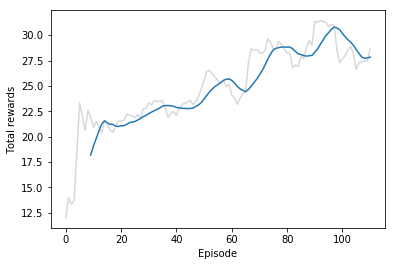

In [182]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

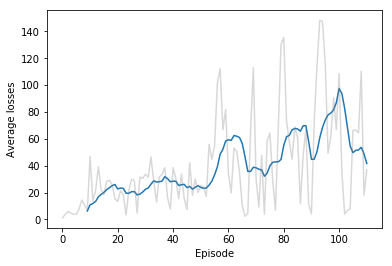

In [183]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.